---
title: 'Lab 4'
author: "Hunter Blinkenberg"
embed-resources: true
format: 
    html:
        toc: true
        code-fold: true
        theme: cosmo
        echo: true
---

In [156]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup
import plotnine as plt
from plotnine import *
import re 

In [102]:
starbucks = requests.get("https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state")

starbs = BeautifulSoup(starbucks.content, "html.parser")

dunkin = requests.get("https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state")

dunkind = BeautifulSoup(dunkin.content, "html.parser")

In [103]:
len(starbs.find_all("table",
                  attrs={
                      "class": "wpr-table",
                      #"style": "text-align:right"
                      }
                  ))

1

## Starbucks Scrape/Locations 

In [104]:
rows = []

for row in starbs.find_all("tr"):
    state_tag = row.find("th")
    cells = row.find_all("td")
    
    if state_tag and len(cells) >= 3:
        state = state_tag.get_text(strip=True)
        s2023 = cells[0].get_text(strip=True)
        s2021 = cells[1].get_text(strip=True)
        s2024 = cells[2].get_text(strip=True)

        rows.append({
            "State": state,
            "s_2023": s2023,
            "s_2021": s2021,
            "s_2024": s2024
        })

#print("Extracted rows:", rows)


In [105]:
starbs_locations = pd.DataFrame(rows)
starbs_locations.columns = ["state", "s_2023", "s_2021", "s_2024"]

## Dunkin Scrape/Locations 

In [106]:
rows2 = []

for row in dunkind.find_all("tr"):
    state_tag = row.find("th")
    cells = row.find_all("td")
    
    if state_tag and len(cells) >= 2:
        state = state_tag.get_text(strip=True)
        d2024 = cells[0].get_text(strip=True)
        d2023 = cells[1].get_text(strip=True)

        rows2.append({
            "State": state,
            "d_2024": d2024,
            "d_2023": d2023,
        })

#print("Extracted rows:", rows2)

In [107]:
dunkind_locations = pd.DataFrame(rows2)
dunkind_locations.columns = ["state", "d_2024", "d_2023"]

In [108]:
coffee= starbs_locations.merge(dunkind_locations, on = "state")

# Supplemental Data

In [109]:
wiki_pop = requests.get("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")

wiki = BeautifulSoup(wiki_pop.content, "html.parser")

In [110]:
table = wiki.find_all("table")[0]

In [111]:
rows3 = []
for row in table.find_all('tr')[1:57]:
    cells = row.find_all('td')
    state = cells[2].text[1:-1]
    pop = cells[3].text[:-1].replace(',', '')

    rows3.append({"state": state,
                 "Population": int(pop)})
    
population = pd.DataFrame(rows3)

In [112]:
coffee= coffee.merge(population, on = "state")

In [113]:
for col in coffee.columns:
    if col not in ["state", "population"]:
        coffee[col] = coffee[col].astype(str).str.replace(',', '')
        coffee[col] = pd.to_numeric(coffee[col], errors='coerce')


In [114]:
coffee["starb_rev2023"] = 36000000000
coffee["starb_rev2021"] = 29100000000
coffee["starb_rev2024"] = 36200000000
coffee["dunkin_rev2023"]= 1400000000


In [115]:
region_dict = {
    'Connecticut': 'Northeast',
    'Maine': 'Northeast',
    'Massachusetts': 'Northeast',
    'New Hampshire': 'Northeast',
    'Rhode Island': 'Northeast',
    'Vermont': 'Northeast',
    'New Jersey': 'Northeast',
    'New York': 'Northeast',
    'Pennsylvania': 'Northeast',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Michigan': 'Midwest',
    'Ohio': 'Midwest',
    'Wisconsin': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Minnesota': 'Midwest',
    'Missouri': 'Midwest',
    'Nebraska': 'Midwest',
    'North Dakota': 'Midwest',
    'South Dakota': 'Midwest',
    'Delaware': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Maryland': 'South',
    'North Carolina': 'South',
    'South Carolina': 'South',
    'Virginia': 'South',
    'District of Columbia': 'South',
    'West Virginia': 'South',
    'Alabama': 'South',
    'Kentucky': 'South',
    'Mississippi': 'South',
    'Tennessee': 'South',
    'Arkansas': 'South',
    'Louisiana': 'South',
    'Oklahoma': 'South',
    'Texas': 'South',
    'Arizona': 'West',
    'Colorado': 'West',
    'Idaho': 'West',
    'Montana': 'West',
    'Nevada': 'West',
    'New Mexico': 'West',
    'Utah': 'West',
    'Wyoming': 'West',
    'Alaska': 'West',
    'California': 'West',
    'Hawaii': 'West',
    'Oregon': 'West',
    'Washington': 'West',
}

coffee['region'] = coffee['state'].map(region_dict)
#coffee.head()

# Analyze

## Are stores more popular in certain regions dispite having less locations overall? 
It seems that Dunkin Donuts is extremely popular in the Northeast despite having less locations overall than starbucks.

In [ ]:
coffee.groupby('region').apply(lambda x: x.groupby('state')['s_2023'].sum().sort_values(ascending=False))

In [ ]:
coffee.groupby('region').apply(lambda x: x.groupby('state')['d_2023'].sum().sort_values(ascending=False))

In [143]:
coffee.groupby('region')["d_2023"].sum()

region
Midwest      1398.0
Northeast    5043.0
South        2557.0
West          363.0
Name: d_2023, dtype: float64

In [144]:
coffee.groupby('region')["s_2023"].sum()

region
Midwest      2468
Northeast    1800
South        4553
West         5923
Name: s_2023, dtype: int64

In [154]:
coffee['s_2023'].sum() / coffee.groupby('region')["s_2023"].sum()

region
Midwest      5.974068
Northeast    8.191111
South        3.238304
West         2.489279
Name: s_2023, dtype: float64

In [141]:
coffee["d_2023"].sum()

np.float64(9361.0)

## Revenues by total number of stores: 
As we can see by the code below, accounting for all of Starbucks stores we see an average revenue of 2.4 million per store in 2023. Dunkin sees an average of 1.49 million in revenue per store in 2023. 

In [149]:
36000000000/ coffee["s_2023"].sum()

np.float64(2441671.1882799785)

In [150]:
1400000000/ coffee["d_2023"].sum()

np.float64(149556.67129580173)

In [145]:
coffee['starb/state'] = coffee["Population"] / coffee["s_2023"]

## Starbucks and Dunkin stores by population: 

We can see that the West shows a slightly higher amount of stores by population, with one huge outlier being California with an extremely disproportionate amount of stores compared to any other state. 

Dunkin sees a huge concentration of stores in the Northeast, which are displayed as green dots in the second scatterplot. 

This shows that Starbucks focuses mostly on the west and specifically California, while Dunkin focuses on the Northeast as a whole. 

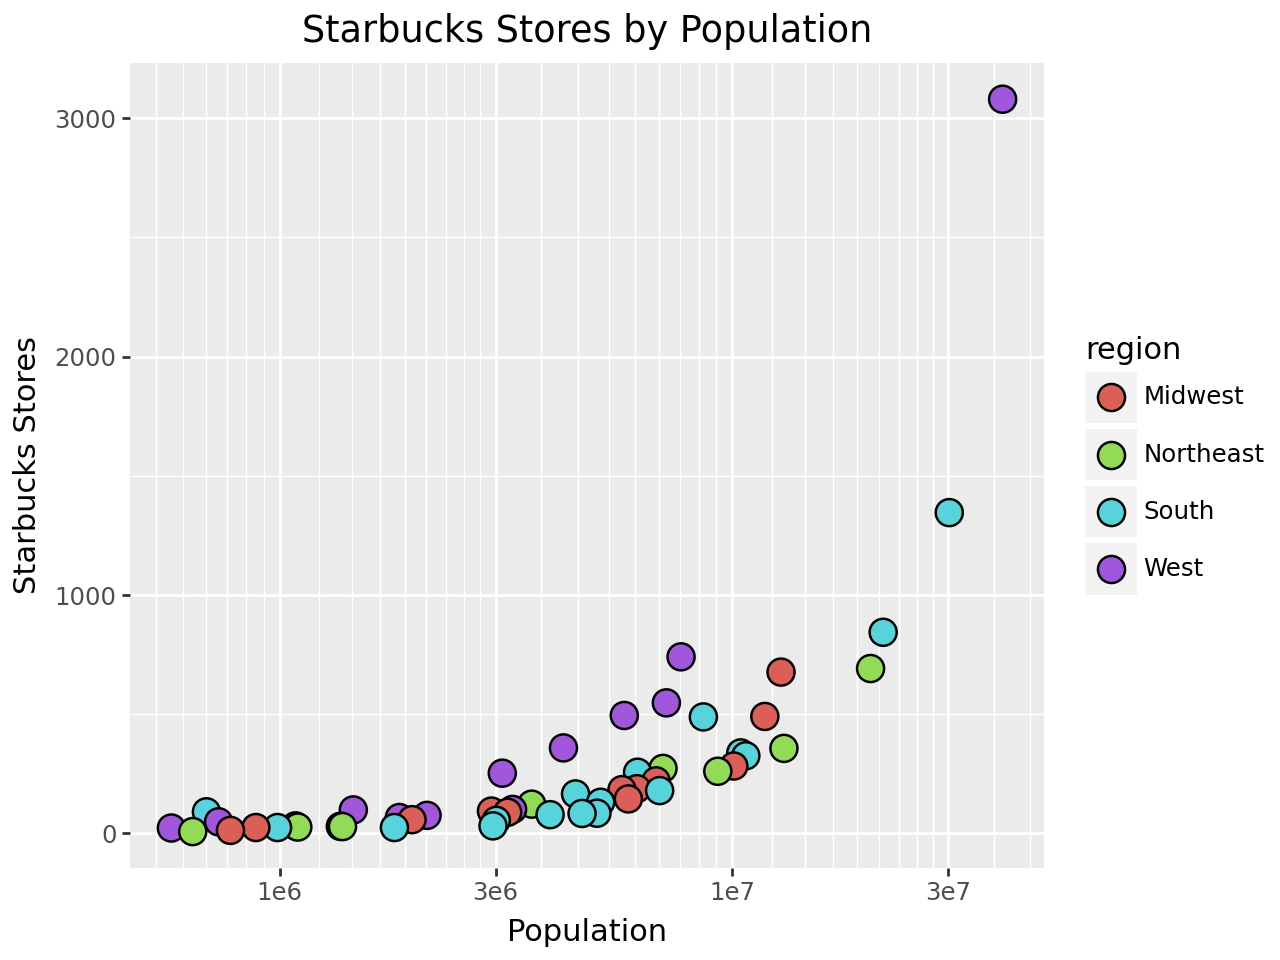

In [151]:
(ggplot(coffee, aes(x='Population', y='s_2023', fill = "region")) + 
        geom_point(size= 5) +
        labs(title="Starbucks Stores by Population", x="Population", y="Starbucks Stores") +
        scale_x_log10())


c:\Users\hblin\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


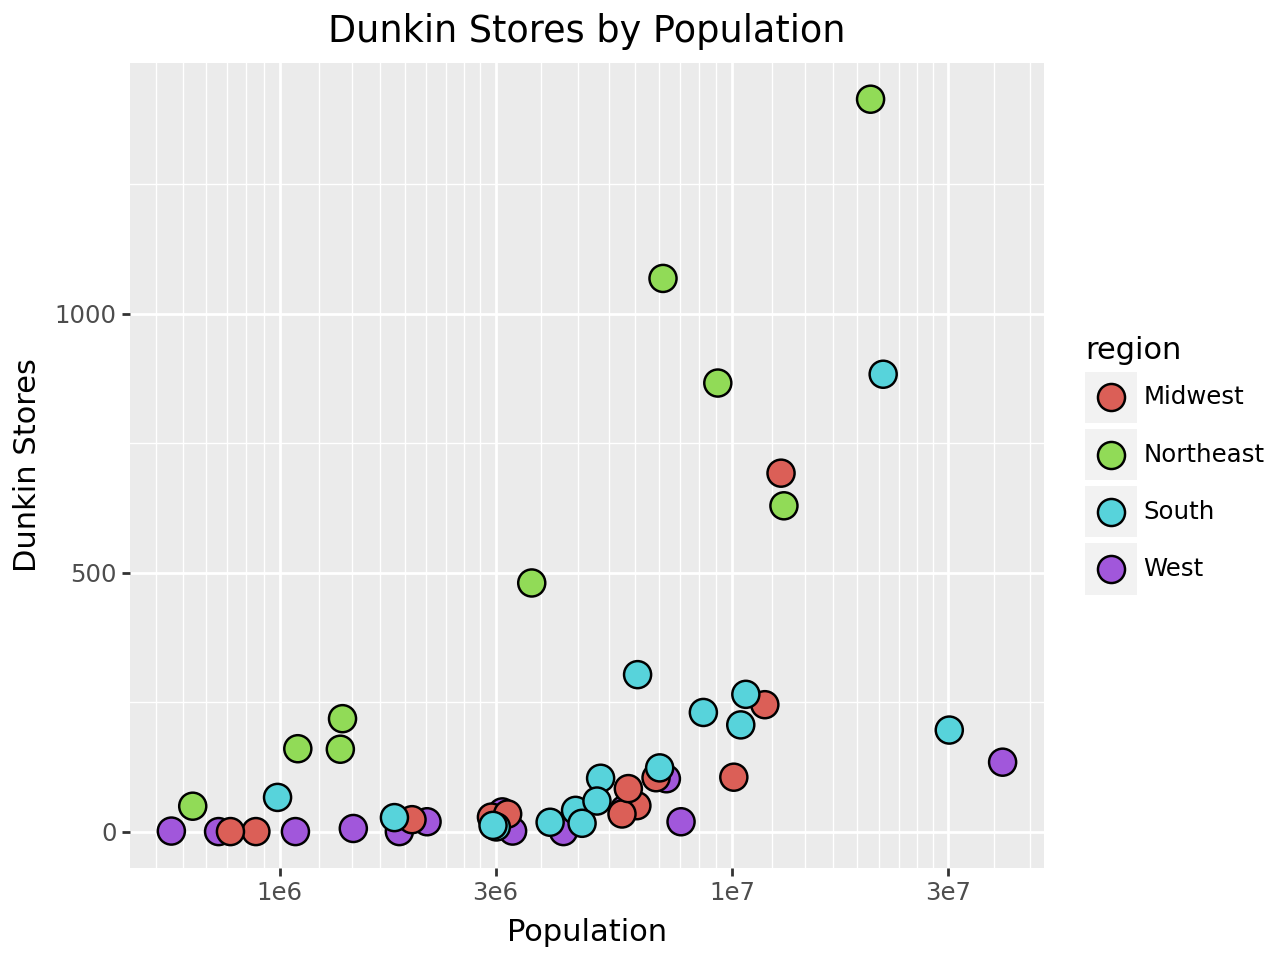

In [153]:
(ggplot(coffee, aes(x='Population', y='d_2023', fill = "region")) + 
        geom_point(size= 5) +
        labs(title="Dunkin Stores by Population", x="Population", y="Dunkin Stores") +
        scale_x_log10())

# Automate

In [160]:

def scrape_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find the company name in the URL
    company_name = re.search(r'(?<=/)[a-z-]+(?=-by-state)', url)
    company_name = company_name.group().replace('-', ' ').title() if company_name else 'Company'
    
    # Scrape the table data
    rows = []
    for row in soup.find_all("tr"):
        state_tag = row.find("th")
        cells = row.find_all("td")
        
        if state_tag and len(cells) >= 3:
            state = state_tag.get_text(strip=True)
            s2023 = cells[0].get_text(strip=True)
            s2021 = cells[1].get_text(strip=True)
            s2024 = cells[2].get_text(strip=True)
            
            rows.append({
                "State": state,
                "2023 Stores": s2023,
                "2021 Stores": s2021,
                "2024 Stores": s2024
            })
    
    # Create the DataFrame
    locations = pd.DataFrame(rows)
    return locations, company_name

# Usage
url = "https://worldpopulationreview.com/country-rankings/starbucks-stores-by-country"
locations, company_name = scrape_data(url)
print(f"{company_name} locations by state:\n", locations.head())


Company locations by state:
            State 2023 Stores 2021 Stores 2024 Stores
0  United States      16,346       9,645       6,701
1          China       6,804       6,804            
2    South Korea       1,870                   1,870
3          Japan       1,733       1,733            
4         Canada       1,458         977         481
